In [1]:
from typing import List,Tuple

from pathlib import Path
import sys
import datetime as dt

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()

from src import paths, baseline
from src.utils.notebooks import download_matplotlib

In [2]:
LAST_FOLDS = 10 # Used for asserts
MAX_CUTOFF = '2023-07-29'
SPLITS_NORMALIZE = True # Wether or not to move everything to 00:00

# COPIED from 31_run_all.ipynb
# Train, Cutoff date, Platform(s), Org Name
# If the platform is none, it will be ALL PLATFORMS
# If the cutoff date is none, it will use last 10 folds
ORGS: List[Tuple[bool, str, str, str, str]] = [
    # The first one, used to test if everything goes fine
    (True, 'W-THU',   MAX_CUTOFF, 'snapshot', 'Decentraland'),
    # ('snapshot', '9K DAO'), # SPAM DAO, says so on snapshot
    # Las propuestas duran 3-4 días
    (False,   '3d',         None, 'snapshot', 'Balancer'),
    # Las propuestas duran 2 días
    # DAO muerta, probando con folds antiguos
    (True,    '2d', '2021-11-28', 'daohaus',  'DEAD FoundationsDAO'),
    # La clásica
    # Las propuestas duran 5 días
    (False,   '5d',         None, 'daostack', 'dxDAO - xDXdao'),
    # ('snapshot', 'gm DAO'), # SPAM DAO, says so on snapshot
    # Las propuestas duran 3 días
    (False,   '3d',         None, 'snapshot', 'HUWA-DAO'),
    # Las propuestas duran 2 días
    (False,   '2d',         None, 'snapshot', 'Index Coop'),
    # Vamos a probar a ver que tal
    (True, 'W-THU', '2020-11-06', ['daohaus', 'snapshot'], 'MetaCartel - MetaCartel Ventures'),
    # Las propuestas duran 3 días
    (True,    '3d', '2023-07-01', 'snapshot', 'PancakeSwap'),
    # La super tocha (ya se entrenará luego)
    (True,    '5d',   MAX_CUTOFF, 'snapshot', 'Aave - Aavegotchi'),
    # ('snapshot', 'WEALTHDAO'), # SPAM DAO, says so on snapshot
]

In [3]:
RESULT_ORGS = [ { 
    'freq': f, 
    'cutoff_date': dt.datetime.fromisoformat(c),
    'platform': p if isinstance(p, str) else ",".join(p),
    'dao': n } 
for t, f, c, p, n in ORGS if t ]
print("Evaluating:", ", ".join( r['dao'] for r in RESULT_ORGS ))

Evaluating: Decentraland, DEAD FoundationsDAO, MetaCartel - MetaCartel Ventures, PancakeSwap, Aave - Aavegotchi


# Loading data and checking some things

In [4]:
def _modelId(row):
    if row['merge'] == '-':
        return row['model']
    else:
        return row['model'] + '-' + row['merge']

_results = []
DO_ORGS = []
for r in RESULT_ORGS:
    p = paths.hybrid_results(r['dao'], r['freq'], SPLITS_NORMALIZE, cutoff_date=r['cutoff_date'])
    if p.exists():
        _results.append(pd.read_csv(p).assign(
            **r
        ))
        DO_ORGS.append(r)
    else:
        print(f"WARNING: File './{p}' does not exist", file=sys.stderr)

dfr = pd.concat(_results)
dfr['modelId'] = dfr.apply(_modelId, axis=1)
dfr

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model,freq,cutoff_date,platform,dao,modelId
0,2023-05-11,avg,0.436576,0.398682,0.532979,0.480288,0.190647,0.256115,0.753254,0.548902,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg
1,2023-05-18,avg,0.313372,0.255105,0.440396,0.417213,0.289941,0.347929,0.563779,0.371812,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg
2,2023-05-25,avg,0.385478,0.332697,0.497991,0.437551,0.195082,0.260656,0.726992,0.528450,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg
3,2023-06-01,avg,0.507858,0.438749,0.612250,0.543638,0.257426,0.368317,0.852505,0.622952,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg
4,2023-06-08,avg,0.552511,0.429311,0.650247,0.524039,0.251695,0.315254,0.859463,0.581487,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55,2023-06-15,-,0.330340,0.326051,0.352136,0.342374,0.052143,0.087857,0.389971,0.365118,gnn,3d,2023-07-01,snapshot,PancakeSwap,gnn
56,2023-06-18,-,0.045473,0.042076,0.082444,0.077054,0.030952,0.044444,0.145989,0.124992,gnn,3d,2023-07-01,snapshot,PancakeSwap,gnn
57,2023-06-21,-,0.026709,0.022158,0.048009,0.036915,0.021854,0.021192,0.061167,0.032066,gnn,3d,2023-07-01,snapshot,PancakeSwap,gnn
58,2023-06-24,-,0.322930,0.318693,0.353871,0.346686,0.076109,0.135154,0.406987,0.385619,gnn,3d,2023-07-01,snapshot,PancakeSwap,gnn


In [5]:
models = dfr['modelId'].unique()
daos = dfr['dao'].unique()

print(f"Analyzing results from {len(daos)} DAOs:", daos)
print(f"Used {len(models)} models:", models)

assert all(dfr.groupby('dao').size() == len(models) * LAST_FOLDS)
assert all(dfr.groupby('modelId').size() == len(daos) * LAST_FOLDS)

Analyzing results from 4 DAOs: ['Decentraland' 'DEAD FoundationsDAO' 'MetaCartel - MetaCartel Ventures'
 'PancakeSwap']
Used 6 models: ['hybrid-avg' 'hybrid-avg_all' 'hybrid-naive' 'hybrid-prioritize' 'nlp'
 'gnn']


## Appending baseline

In [6]:
_baselines = []
for dao in DO_ORGS:
    _baselines.append(baseline
    .read_metrics_baseline(dao['dao'], dao['freq'], SPLITS_NORMALIZE, cutoff_date=dao['cutoff_date'])[-LAST_FOLDS:]
    .reset_index()
    .assign(model='baseline', merge='-', modelId='baseline', **dao)
    )

dfrb = pd.concat([dfr] + _baselines)
dfrb

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model,freq,cutoff_date,platform,dao,modelId,precision@15,ndcg@15,map@15,recall@15
0,2023-05-11,avg,0.436576,0.398682,0.532979,0.480288,0.190647,0.256115,0.753254,0.548902,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
1,2023-05-18,avg,0.313372,0.255105,0.440396,0.417213,0.289941,0.347929,0.563779,0.371812,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
2,2023-05-25,avg,0.385478,0.332697,0.497991,0.437551,0.195082,0.260656,0.726992,0.528450,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
3,2023-06-01,avg,0.507858,0.438749,0.612250,0.543638,0.257426,0.368317,0.852505,0.622952,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
4,2023-06-08,avg,0.552511,0.429311,0.650247,0.524039,0.251695,0.315254,0.859463,0.581487,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2023-06-17 23:49:44,-,0.018561,0.015414,0.033327,0.025878,0.014762,0.015238,0.045535,0.024958,baseline,3d,2023-07-01,snapshot,PancakeSwap,baseline,0.018413,0.048997,0.023429,0.095110
6,2023-06-20 23:20:15,-,0.017181,0.013877,0.032777,0.025549,0.015812,0.017094,0.046501,0.025631,baseline,3d,2023-07-01,snapshot,PancakeSwap,baseline,0.019943,0.049570,0.022559,0.098297
7,2023-06-23 23:57:05,-,0.385905,0.380219,0.415198,0.402482,0.086436,0.155851,0.462912,0.428426,baseline,3d,2023-07-01,snapshot,PancakeSwap,baseline,0.060461,0.418682,0.387149,0.473889
8,2023-06-26 23:34:01,-,0.065913,0.056769,0.110307,0.089688,0.038816,0.047368,0.179195,0.109432,baseline,3d,2023-07-01,snapshot,PancakeSwap,baseline,0.035088,0.121175,0.070175,0.207174


In [7]:
_perfect = []
for dao in DO_ORGS:
    _perfect.append(baseline
    .read_metrics_perfect(dao['dao'], dao['freq'], SPLITS_NORMALIZE, cutoff_date=dao['cutoff_date'])[-LAST_FOLDS:]
    .reset_index()
    .assign(model='perfect', merge='-', modelId='perfect', **dao)
    )

dfrbp = pd.concat([dfrb] + _perfect)
dfrbp

,t,merge,map@10,map@5,ndcg@10,ndcg@5,precision@10,precision@5,recall@10,recall@5,model,freq,cutoff_date,platform,dao,modelId,precision@15,ndcg@15,map@15,recall@15
0,2023-05-11,avg,0.436576,0.398682,0.532979,0.480288,0.190647,0.256115,0.753254,0.548902,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
1,2023-05-18,avg,0.313372,0.255105,0.440396,0.417213,0.289941,0.347929,0.563779,0.371812,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
2,2023-05-25,avg,0.385478,0.332697,0.497991,0.437551,0.195082,0.260656,0.726992,0.528450,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
3,2023-06-01,avg,0.507858,0.438749,0.612250,0.543638,0.257426,0.368317,0.852505,0.622952,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
4,2023-06-08,avg,0.552511,0.429311,0.650247,0.524039,0.251695,0.315254,0.859463,0.581487,hybrid,W-THU,2023-07-29,snapshot,Decentraland,hybrid-avg,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,2023-06-17 23:49:44,-,0.992330,0.976985,1.000000,1.000000,0.215714,0.400000,0.992330,0.976985,perfect,3d,2023-07-01,snapshot,PancakeSwap,perfect,0.148571,1.0,0.995637,0.995637
6,2023-06-20 23:20:15,-,0.988482,0.947266,1.000000,1.000000,0.266667,0.452991,0.988482,0.947266,perfect,3d,2023-07-01,snapshot,PancakeSwap,perfect,0.185755,1.0,0.995344,0.995344
7,2023-06-23 23:57:05,-,0.995267,0.978547,1.000000,1.000000,0.209840,0.386702,0.995267,0.978547,perfect,3d,2023-07-01,snapshot,PancakeSwap,perfect,0.142908,1.0,0.997554,0.997554
8,2023-06-26 23:34:01,-,0.995301,0.975029,1.000000,1.000000,0.219079,0.400000,0.995301,0.975029,perfect,3d,2023-07-01,snapshot,PancakeSwap,perfect,0.148246,1.0,0.996241,0.996241


# Making some graphs

In [8]:
# TODO: Make a function that, given a metric,
# plots a graph bar of all the daos and its average
# resuls over the different models

# Perhaps each color is each dao and different
# bars are the different models, or each color
# is each model, and each bar is each dao
# If you do it with seaborn it should be easy to change

<Axes: xlabel='dao', ylabel='precision@5'>

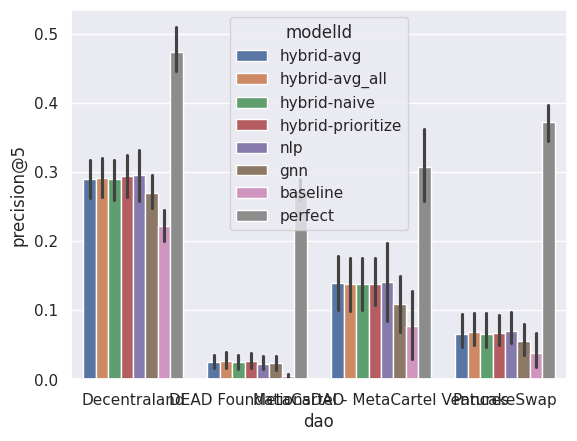

In [9]:
def plot_all_daos_metric(metric):
    _id_vars = ['t', 'dao', 'modelId']
    # _metrics = [ c for c in dfr.columns if '@' in c ]
    # _toplot = dfr.melt(id_vars=_id_vars, value_vars=_metrics)
    _toplot = dfrbp[_id_vars + [metric]]
    return sns.barplot(_toplot, x='dao', y=metric, hue='modelId')

plot_all_daos_metric('precision@5')

<Axes: xlabel='dao', ylabel='ndcg@10'>

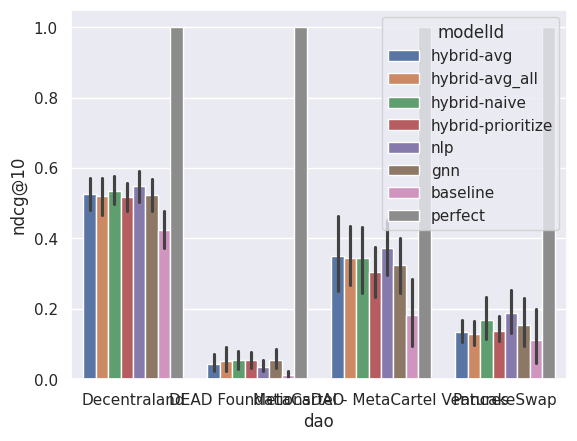

In [10]:
plot_all_daos_metric('ndcg@10')

## Now different graphs

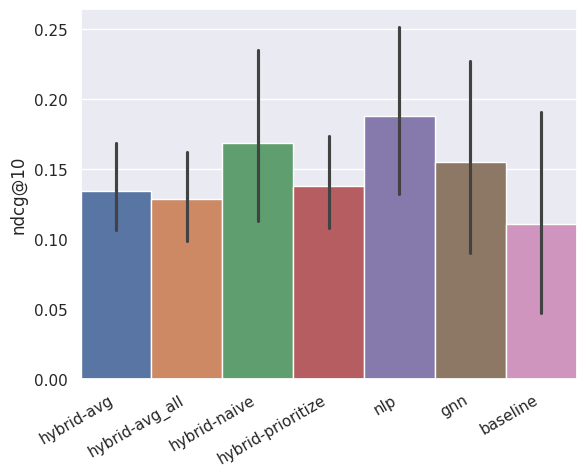

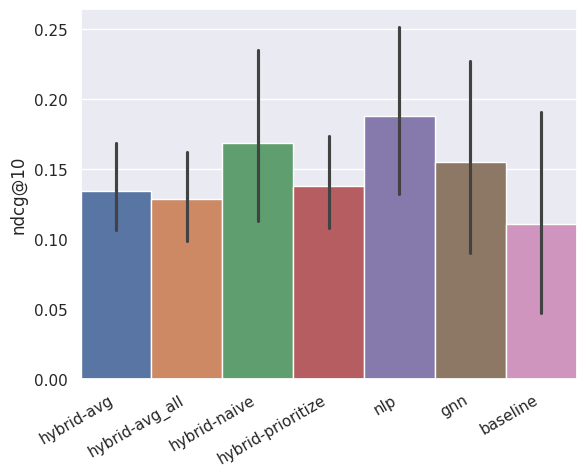

In [11]:
def plot_one_dao_metric(daoName, metric):
    _toplot = dfrbp[(dfrbp['dao'] == daoName) & (dfrbp['modelId'] != 'perfect')]
    fig = sns.barplot(_toplot, x='modelId', y=metric, hue='modelId', width=1)
    plt.xticks(rotation=30, ha='right')
    plt.xlabel("")
    return fig.figure

plot_one_dao_metric('PancakeSwap', 'ndcg@10')

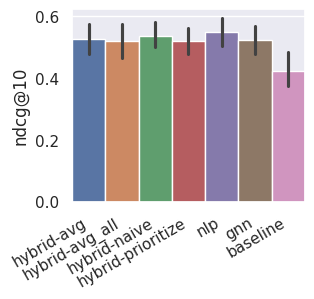

Cannot show ipywidgets in text

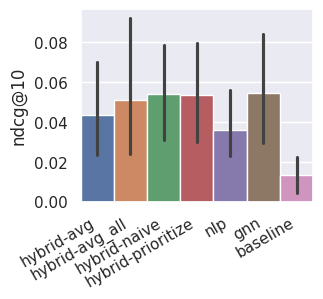

Cannot show ipywidgets in text

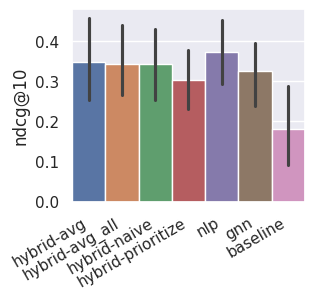

Cannot show ipywidgets in text

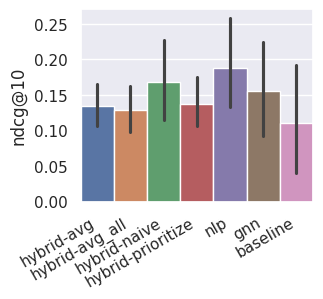

Cannot show ipywidgets in text

[<Figure size 300x250 with 1 Axes>,
 <Figure size 300x250 with 1 Axes>,
 <Figure size 300x250 with 1 Axes>,
 <Figure size 300x250 with 1 Axes>]

In [12]:
def plot_all_daos_metric_figs(metric):
    figs = []
    for dao in DO_ORGS:
        plt.figure(figsize=(3,2.5))
        fig = plot_one_dao_metric(dao['dao'], metric)
        display(fig)
        display(download_matplotlib(fig, f'7_all-metrics-{dao["dao"]}-{metric}.pdf'))
        plt.close()
        figs.append(fig)
    return figs

plot_all_daos_metric_figs('ndcg@10')

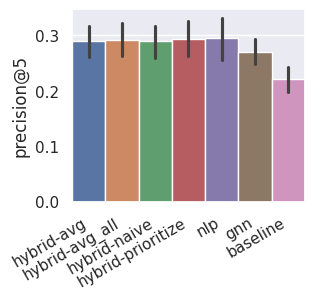

Cannot show ipywidgets in text

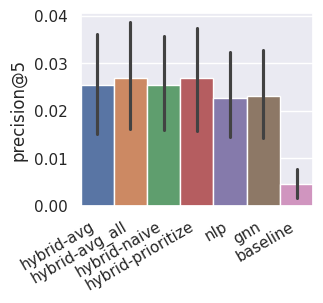

Cannot show ipywidgets in text

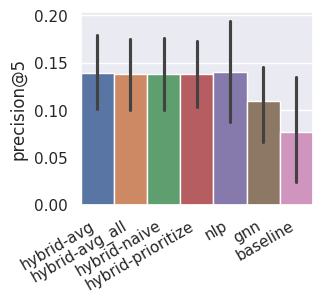

Cannot show ipywidgets in text

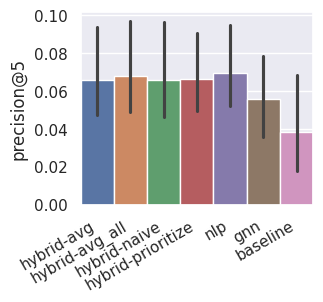

Cannot show ipywidgets in text

[<Figure size 300x250 with 1 Axes>,
 <Figure size 300x250 with 1 Axes>,
 <Figure size 300x250 with 1 Axes>,
 <Figure size 300x250 with 1 Axes>]

In [13]:
plot_all_daos_metric_figs('precision@5')